In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pathlib import Path
import matplotlib
#import tensorflow as tf

In [31]:
DISTANCE_FOLDER = Path("Distance_model")
ANGLE_FOLDER = Path("Angle_model")

# defining the prediction type (angle based or distance based)
USE_DISTANCE_MODEL = True # set this to true to use distance for the model input or to false to use angles for the model input
ANN_ANGLE_MODEL_INFO = [ANGLE_FOLDER/'Section4_new_ANN_7', ANGLE_FOLDER/'Section4_new_scaler_ANN_7.pkl'] # used for USE_DISTANCE_MODEL = False case (it will do all the predictions from the same model)
ANN_DISTANCE_MODEL_CATALOG = {(1.5, 3): [DISTANCE_FOLDER/'Section1_ANN_3', DISTANCE_FOLDER/'Section1_scaler_ANN_3.pkl'],
							  (3, 7): [DISTANCE_FOLDER/'Section2_new_ANN_5', DISTANCE_FOLDER/'Section2_new_scaler_ANN_5.pkl'],
							  (7, 13): [DISTANCE_FOLDER/'Section3_new_ANN_1', DISTANCE_FOLDER/'Section3_new_scaler_ANN_1.pkl'],
							  (13, 19): [DISTANCE_FOLDER/'Section4_new_ANN_1', DISTANCE_FOLDER/'Section4_new_scaler_ANN_1.pkl'],
							  (19, 25): [DISTANCE_FOLDER/'Section5_new_ANN_1', DISTANCE_FOLDER/'Section5_new_scaler_ANN_1.pkl'],
							  (25, 30): [DISTANCE_FOLDER/'Section6_new_ANN_1', DISTANCE_FOLDER/'Section6_new_scaler_ANN_1.pkl']} # ANN models for different sections (a dictionary of range:model name pairs) used for the USE_DISTANCE_MODEL = True
'''
ANN_ARRIVAL_TIME_MODEL_FILE = ANGLE_FOLDER/'Arrival_ANN4' # fix this
ANN_CHANGE_TIME_MODEL_FILE = ANGLE_FOLDER/'Change_ANN1' # fix this
ANN_END_TIME_MODEL_FILE = ANGLE_FOLDER/'End_ANN4' # fix this
'''
ANN_ARRIVAL_TIME_MODEL_FILE = DISTANCE_FOLDER/'Arrival_ANN_1' # fix this
ANN_CHANGE_TIME_MODEL_FILE = DISTANCE_FOLDER/'Change_ANN_3' # fix this
ANN_END_TIME_MODEL_FILE = DISTANCE_FOLDER/'End_ANN_2' # fix this

EXPORT_UNIQUE_ANGLES_OR_DISTANCES = True # set this to true to write the file with unique values of angles or distances

In [36]:
# defining parameters for neural network prediction
EXPLOSIVE_MASS = 16.2
DISTANCE_EXPLOSIVE_TO_SURFACE = 11.4
CORNER_COORDINATES_OF_SURFACE = ([0, 0], [4, 0], [0, 4], [4, 4])  # ll, lr, ul, ur
EXPLOSIVE_POSITION = [0, 0]
MESH_SIZE = 0.01
CONSIDERED_TIME = 25

# defining parameters for numerical analysis results processing
NUMERICAL_ANGLE_BASED_PREDICTION_FILE = ANGLE_FOLDER/f'angle_based_numerical_prediction_{CONSIDERED_TIME}s.csv'
NUMERICAL_DISTANCE_BASED_PREDICTION_FILE = 'distance_based_numerical_prediction.csv'

In [37]:
def generate_surface_coordinates(corner_coordinates, mesh_size):
	print ("2")
	print('Generating surface coordinates...')
	ll, lr, ul, ur = corner_coordinates

	# Generate grid of coordinates with mesh size
	x_range = np.arange(ll[0], lr[0] + mesh_size, mesh_size)
	y_range = np.arange(ll[1], ul[1] + mesh_size, mesh_size)[::-1]  # Reverse y_range to match the matrix orientation
	x_coords, y_coords = np.meshgrid(x_range, y_range)

	# Create a 2D matrix with coordinates in corresponding positions
	surface_matrix = np.empty_like(x_coords, dtype=object)
	for i in range(surface_matrix.shape[0]):
		for j in range(surface_matrix.shape[1]):
			surface_matrix[i, j] = (x_coords[i, j], y_coords[i, j])

	return surface_matrix

def calculate_angles(surface_matrix, distance_explosive_to_surface):
    origin_x, origin_y = 0, 0

    angle_surface_matrix = np.empty(surface_matrix.shape, dtype=object)
    for i in range(surface_matrix.shape[0]):
        for j in range(surface_matrix.shape[1]):
            distance_from_origin_to_point = np.sqrt((surface_matrix[i, j][0] - origin_x) ** 2 + (surface_matrix[i, j][1] - origin_y) ** 2)
            angle_radians = np.arctan(distance_from_origin_to_point / distance_explosive_to_surface)  # find the angle
            angle_degrees = np.degrees(angle_radians)  # Convert radians to degrees
            angle_degrees = np.round(np.round(angle_degrees / 0.2) * 0.2,1)  # Round to nearest 0.2 degrees
            angle_surface_matrix[i, j] = angle_degrees  # Store angle in degrees
    return angle_surface_matrix

def calculate_distances(surface_matrix, distance_explosive_to_surface):
	origin_x, origin_y = 0, 0
	distance_surface_matrix = np.empty(surface_matrix.shape, dtype=object)
	for i in range(surface_matrix.shape[0]):
		for j in range(surface_matrix.shape[1]):
			distance_from_origin_to_point = np.sqrt((surface_matrix[i, j][0] - origin_x) ** 2 + (surface_matrix[i, j][1] - origin_y) ** 2)
			distance_from_explosive_to_point = np.sqrt(distance_explosive_to_surface ** 2 + distance_from_origin_to_point ** 2)  # find the distance
			distance_surface_matrix[i, j] = np.round(distance_from_explosive_to_point*100)/100 # round to nearest 0.1
	return distance_surface_matrix

def generate_a_random_2d_matrix(width, height):
	random_matrix = np.random.rand(height, width)
	return random_matrix

def generate_heatmap(random_heatmap_df, surface_coordinates_df, prediction_method):
	print('generating heatmap...')
	
	cdict = {'red': ((0.0, 0.0, 0.0),
			 (0.25, 0.2, 0.2),
			 (0.5, 0.0, 0.0),
			 (0.75, 1.0, 1.0),
			 (1.0, 1.0, 1.0)),
			 'green':((0.0, 0.0, 0.0),
			 (0.25, 1.0, 1.0),
			 (0.5, 1.0, 1.0),
			 (0.75, 1.0, 1.0),
			 (1.0, 0.0, 0.0)),
			 'blue': ((0.0, 1.0, 1.0),
			 (0.25, 1.0, 1.0),
			 (0.5, 0.0, 0.0),
			 (0.75, 0.0, 0.0),
			 (1.0, 0.0, 0.0))}
	my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
	
	# Reshape the random heatmap DataFrame to match the surface_coordinates_df
	heatmap_values = random_heatmap_df.values.reshape(surface_coordinates_df.shape[0], surface_coordinates_df.shape[1])
	
	plt.gcf()
	plt.rcParams['font.family'] = 'serif'
	plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
	plt.gcf().set_size_inches(5,5)
	plt.rcParams['font.size'] = 18
	
	# Define the upper and lower bounds for the color bar
	vmin_value = 107  # Lower bound
	vmax_value = 123  # Upper bound

	# Create heatmap with x and y coordinates as axis ticks
	plt.imshow(heatmap_values, cmap=my_cmap, extent=[surface_coordinates_df[0, 0][0],
													 surface_coordinates_df[-1, -1][0],
													 surface_coordinates_df[-1, -1][1],
													 surface_coordinates_df[0, 0][1]],
			   										vmin=vmin_value, vmax=vmax_value)
	colorbar = plt.colorbar(shrink = 0.8)
	colorbar.ax.tick_params(labelsize=18)  # Set fontsize for ticks
	#colorbar.set_ticks([110,120,130,140,150,160])
	colorbar.set_label('Error %' if prediction_method == 'Error Percentages' else 'Overpressure (kPa)',fontsize=18)
	
	plt.xlabel('X (m)')
	plt.ylabel('Y (m)')
	plt.title('Overpressure Distribution: ' + ('Incident' if USE_DISTANCE_MODEL else 'Reflected') + ' : ' + prediction_method, pad=20, fontsize = 15)
	# Determine the folder path based on USE_DISTANCE_MODEL
	folder_path = "Distance_model" if USE_DISTANCE_MODEL else "Angle_model"
	plt.savefig(f'{folder_path}/{prediction_method}_{DISTANCE_EXPLOSIVE_TO_SURFACE}m{EXPLOSIVE_MASS}kg{CONSIDERED_TIME}s.png', dpi=200, bbox_inches='tight')
	plt.show()


def phase_calculation(x_dataset, arrival_times, change_times, end_times, considered_time):
	print("6")
	"""
	:param x_dataset: The dataset used for calculations
	:param arrival_times: The predicted arrival times
	:param change_times: The predicted change times
	:param end_times: The predicted end times
	:param considered_time: The considered time
	:return: int array indicating positive phase (1 = true, 0 = false, -1 = not in the range)
	"""
	print('Phase Calculation...')
	# Initialize the phase array
	is_positive_phase = np.zeros(len(x_dataset), dtype=int)

	# Loop through each time and apply the logic
	for i in range(len(x_dataset)):
		arrival_time = arrival_times[i]
		change_time = change_times[i]
		end_time = end_times[i]

		# If considered_time is between arrival_time and change_time
		if arrival_time <= considered_time < change_time:
			is_positive_phase[i] = 1
		# If considered_time is between change_time and end_time
		elif change_time <= considered_time <= end_time:
			is_positive_phase[i] = 0
		# if it is not in the range of arrival_time and end_time
		else:
			is_positive_phase[i] = -1

	return is_positive_phase

def calculate_phase_workflow(x_dataset, considered_time):
	print ("5")
	'''
	:param x_dataset: for use_distance_model x dataset includes [mass, distance], for angle model x dataset includes [mass, distance_explosive_to_surface, angle]
	:return: int array of phases (1 = positive phase, 0 = negative phase, -1 = not in the range)
	'''
	print('Calculating phase...')
	# predict arrival time
	arrival_time_predictions = predict_arrival_time(ANN_ARRIVAL_TIME_MODEL_FILE, x_dataset)
	print('arrival_time_predictions: ',  arrival_time_predictions)
	# predict change time
	change_time_predictions = predict_change_time(ANN_CHANGE_TIME_MODEL_FILE, x_dataset)
	# predict end time
	end_time_predictions = predict_end_time(ANN_END_TIME_MODEL_FILE, x_dataset)
	# calculate phase
	is_positive_phase = phase_calculation(x_dataset, arrival_time_predictions, change_time_predictions, end_time_predictions, considered_time)

	return is_positive_phase

def generate_x_dataset(use_distance_model, surface_coordinates, distance_explosive_to_surface, explosive_mass, consideredTime):
	'''
	:param use_distance_model:
	:param surface_coordinates:
	:param distance_explosive_to_surface:
	:param explosive_mass:
	:param consideredTime:
	:return: X dataset wit the below column order:
	DISTANCE_MODEL = mass, surface_coordinates_distance, time, phaseNegative, phasePositive
	ANGLE_MODEL = mass, distance_explosive_to_surface, surface_coordinates_angles, time, phase, phaseNegative, phasePositive
	'''
	print("3")
	print("Generating X dataset...")
	# calculate the angles or distances to the pints in the surface from the explosive location
	if not use_distance_model: # use angles
		surface_coordinates_angles_or_distances = calculate_angles(surface_coordinates, distance_explosive_to_surface)
	else: # use distances
		surface_coordinates_angles_or_distances = calculate_distances(surface_coordinates, distance_explosive_to_surface)

	# flatten the surface coordinates/distances into a 1D array
	surface_coordinates_angles_or_distances_flat = surface_coordinates_angles_or_distances.flatten()

	if EXPORT_UNIQUE_ANGLES_OR_DISTANCES: # whether or not to write the unique values to a file
		file_name = ('unique_distances' if use_distance_model else 'unique_angles') +'_'+ str(DISTANCE_EXPLOSIVE_TO_SURFACE) + 'm' + str(EXPLOSIVE_MASS) + 'kg' + str(CONSIDERED_TIME) + 's' + '.csv'
		uniques = np.unique(surface_coordinates_angles_or_distances_flat)
		# Write the unique values to the CSV file
		folder_path = "Distance_model" if USE_DISTANCE_MODEL else "Angle_model"
		np.savetxt(f'{folder_path}/{file_name}', uniques, delimiter=',', fmt='%s')

	# Create a 2D matrix with the specified columns
	num_points = len(surface_coordinates_angles_or_distances_flat)
	x_dataset = np.zeros((num_points, (5 if use_distance_model else 6)))

	x_dataset[:, 0] = explosive_mass  # Set the first column to explosive_mass
	if use_distance_model:
		x_dataset[:, 1] = surface_coordinates_angles_or_distances_flat  # Set the second column to surface_coordinates_distances_flat
	else:
		x_dataset[:, 1] = distance_explosive_to_surface  # Set the second column to distance_explosive_to_surface
		x_dataset[:, 2] = surface_coordinates_angles_or_distances_flat  # Set the third column to surface_coordinates_angles_flat

	# calculate the phase
	is_positive_phase = calculate_phase_workflow((x_dataset[:, :2] if use_distance_model else x_dataset[:, :3]), consideredTime)
	if use_distance_model:
		x_dataset[:, 2] = consideredTime  # Set the third column to consideredTime
		# Set the fourth and fifth columns based on the phase results
		x_dataset[:, 3] = np.where(is_positive_phase == 0, 1, 0)  # Set 1 for negative phase, 0 otherwise
		x_dataset[:, 4] = np.where(is_positive_phase == 1, 1, 0)  # Set 1 for positive phase, 0 otherwise
	else:
		x_dataset[:, 3] = consideredTime  # Set the fourth column to consideredTime
		# Set the fifth and sixth columns based on the phase results
		x_dataset[:, 4] = np.where(is_positive_phase == 0, 1, 0)  # Set 1 for negative phase, 0 otherwise
		x_dataset[:, 5] = np.where(is_positive_phase == 1, 1, 0)  # Set 1 for positive phase, 0 otherwise
	
	print (x_dataset)

	return x_dataset, is_positive_phase


def predict_pressures(ann_model_catalog, x_dataset, is_positive_phase):
	print('Predicting pressures...')
	# Initialize an array to hold all predictions, with default values set to 0 for is_positive_phase == -1
	all_predictions = np.zeros((x_dataset.shape[0],))

	# Skip predictions for entries where is_positive_phase == -1
	valid_entries = is_positive_phase != -1

	if USE_DISTANCE_MODEL:
		for i, (distance_range, model_data) in enumerate(ann_model_catalog.items()):
			lower_bound, upper_bound = distance_range
			model = load_model(model_data[0])

			# Filter the x_dataset's entries based on the distance range (x_dataset[:, 1])
			if i == 0:
				# For the first model, include both lower and upper bounds
				relevant_entries = (x_dataset[:, 1] >= lower_bound) & (x_dataset[:, 1] <= upper_bound) & valid_entries
			else:
				# For consecutive models, include only the upper bound
				relevant_entries = (x_dataset[:, 1] <= upper_bound) & (x_dataset[:, 1] > lower_bound) & valid_entries

			# Get the subset of x_dataset where the distance is within the relevant range
			filtered_x_dataset = x_dataset[relevant_entries]

			if len(filtered_x_dataset) > 0:  # Make predictions only if there are relevant entries
				scaler = pickle.load(open(model_data[1], 'rb'))
				filtered_x_dataset_scaled = filtered_x_dataset
				filtered_x_dataset_scaled[:, 0:3] = scaler.transform(filtered_x_dataset[:, 0:3])
				predictions = model.predict(filtered_x_dataset_scaled)
				all_predictions[relevant_entries] = predictions.flatten()  # Consolidate predictions
	else:
		# Apply to all valid entries if using the angle model
		relevant_entries = valid_entries
		model = load_model(ANN_ANGLE_MODEL_INFO[0])
		filtered_x_dataset = x_dataset[relevant_entries]

		if len(filtered_x_dataset) > 0:
			scaler = pickle.load(open(ANN_ANGLE_MODEL_INFO[1], 'rb'))
			filtered_x_dataset_scaled = filtered_x_dataset
			filtered_x_dataset_scaled[:, 0:4] = scaler.transform(filtered_x_dataset[:, 0:4])
			predictions = model.predict(filtered_x_dataset_scaled)
			all_predictions[relevant_entries] = predictions.flatten()

	return all_predictions

def predict_arrival_time(ann_model_file, x_dataset):
	print('predict_arrival_time')
	model = load_model(ann_model_file)
	predictions = model(x_dataset)

	return predictions

def predict_change_time(ann_model_file, x_dataset):
	print('predict_change_time')
	model = load_model(ann_model_file)
	predictions = model.predict(x_dataset)

	return predictions

def predict_end_time(ann_model_file, x_dataset):
	print('predict_end_time')
	model = load_model(ann_model_file)
	predictions = model.predict(x_dataset)

	return predictions

def read_numerical_analysis_results():
	# assumption: fist column includes the angles/distance and second column includes the numerical analysis results
	if USE_DISTANCE_MODEL:
		numerical_results = pd.read_csv(NUMERICAL_DISTANCE_BASED_PREDICTION_FILE, header=None)
	else:
		numerical_results = pd.read_csv(NUMERICAL_ANGLE_BASED_PREDICTION_FILE, header=None)
	return numerical_results

def map_numerical_predictions_to_2d_surface(surface_coordinates_angles_or_distances, numerical_results):
	# Create a mapping from values in the first column of numerical_results (which represents angles or distances) to the values in the surface_coordinates_angles_or_distances
	mapping = dict(zip(numerical_results.iloc[:, 0], numerical_results.iloc[:, 1]))

	# Replace values in the ndarray using the mapping
	mapped_values = np.array([mapping[round(value,2)] for value in surface_coordinates_angles_or_distances])

	return mapped_values

def neural_network_workflow():
	print("1")
	# Generate surface coordinates
	surface_coordinates = generate_surface_coordinates(CORNER_COORDINATES_OF_SURFACE, MESH_SIZE)

	# generate the x dataset
	x_dataset, is_positive_phase = generate_x_dataset(USE_DISTANCE_MODEL, surface_coordinates, DISTANCE_EXPLOSIVE_TO_SURFACE, EXPLOSIVE_MASS, CONSIDERED_TIME)

	# load the ANN model and predict for the x_dataset
	predictions = predict_pressures(ANN_DISTANCE_MODEL_CATALOG, x_dataset, is_positive_phase)

	# add a base value to the predicted pressures 101.25
	predictions += 101.25
	print ("Max NN prediction:", max(predictions), "Min NN predictions:", min(predictions))
	predictions_df = pd.DataFrame(predictions.flatten(), columns=['value'])

	# Generate heatmap
	generate_heatmap(predictions_df, surface_coordinates, 'NN')

	return surface_coordinates, x_dataset, predictions_df

def process_numerical_model_results(surface_coordinates_angles_or_distances, surface_coordinates):
	# read the corresponding numerical analysis results file
	numerical_analysis_results = read_numerical_analysis_results()

	# map the numerical analysis results to the corresponding surface_coordinates_angles_or_distances
	mapped_numerical_analysis_results = map_numerical_predictions_to_2d_surface(surface_coordinates_angles_or_distances, numerical_analysis_results)
	mapped_numerical_analysis_results_df = pd.DataFrame(mapped_numerical_analysis_results.flatten(), columns=['value'])

	# Generate heatmap
	generate_heatmap(mapped_numerical_analysis_results_df, surface_coordinates, 'NA')

	return mapped_numerical_analysis_results_df

In [38]:
def calculate_error_percentages(nn_prediction_results, na_prediction_results, surface_coordinates):
	# Calculate errors
	errors = nn_prediction_results - na_prediction_results

	# Calculate percentage errors
	percentage_errors = (errors / na_prediction_results) * 100

	generate_heatmap(percentage_errors, surface_coordinates, 'Error Percentages')




def main():
	### NEURAL NETWORK PREDICTION AND VISUALIZATION ###
	surface_coordinates, x_dataset, nn_prediction_results = neural_network_workflow()

	### NUMERICAL METHOD RESULTS PROCESSING ###
	#na_prediction_results = process_numerical_model_results(x_dataset[:, 1] if USE_DISTANCE_MODEL else x_dataset[:, 2], surface_coordinates) # pass the correct column from the x_dataset (angles or distances)

	### ERROR PERCENTAGE CALCULATIONS ###
	#calculate_error_percentages(nn_prediction_results, na_prediction_results, surface_coordinates)

1
2
Generating surface coordinates...
3
Generating X dataset...
5
Calculating phase...
predict_arrival_time
arrival_time_predictions:  tf.Tensor(
[[22.195877]
 [22.195877]
 [22.195877]
 ...
 [22.16931 ]
 [22.195877]
 [22.195877]], shape=(160801, 1), dtype=float32)
predict_change_time
5026/5026 [==============================] - 9s 2ms/step
predict_end_time
5026/5026 [==============================] - 9s 2ms/step
6
Phase Calculation...
[[16.2  12.08 25.    0.    1.  ]
 [16.2  12.08 25.    0.    1.  ]
 [16.2  12.08 25.    0.    1.  ]
 ...
 [16.2  12.07 25.    0.    1.  ]
 [16.2  12.08 25.    0.    1.  ]
 [16.2  12.08 25.    0.    1.  ]]
Predicting pressures...


D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


5026/5026 [==============================] - 8s 2ms/step
Max NN prediction: 122.79574775695801 Min NN predictions: 107.32105350494385
generating heatmap...


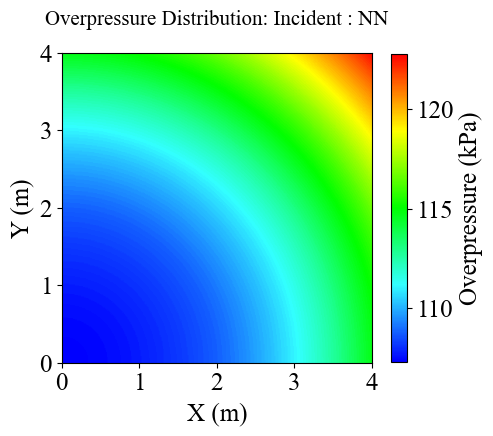

In [39]:
main()